<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-07-tree-based-models-bagging-grf-probability-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.8.7 Probability Forest

A **Probability Forest** is a machine learning model based on the random forest framework, designed to estimate **conditional probabilities** for categorical outcomes. It extends the standard random forest classifier by outputting the probability of each class for a given set of covariates, rather than just predicting the most likely class. It is implemented in packages like `{grf}` in R (as `probability_forest`) and is particularly useful for tasks requiring probabilistic predictions, such as risk estimation or classification with uncertainty quantification. Below, I’ll explain what it is, how it works, and its key features, keeping it concise and clear.


## Overview

Probability Forest Estimates the conditional probability $P(Y = k | X)$) for each class $k$ of a categorical outcome $Y$, given covariates $X$. For example, it can predict the probability of a patient having a disease (yes/no) based on features like age or symptoms.




### Key Features

-   `Non-Parametric`: Captures complex, non-linear relationships between $X$ and $Y$.
-   `Robustness`: Averaging over many trees reduces overfitting and improves generalization.
-   `Heterogeneity`: Estimates probabilities that vary across individuals based on covariates.
-   `Calibration`: In `{grf}`, probabilities are well-calibrated due to honest estimation and local smoothing.
-   `Multi-Class Support`: Handles binary or multi-class outcomes seamlessly.


### How It Work

A Probability Forest builds on the random forest algorithm but focuses on estimating class probabilities. Here’s a step-by-step overview:

1.  Data Setup

   -   `Input`: Covariates $X$ (e.g., age, sex) and a categorical outcome $Y$ (e.g., 0/1 for binary, or multiple classes).
   -   $Y$ is typically a factor or integer vector indicating class labels.

2.  Tree Construction

   -   Like a standard random forest, it grows multiple decision trees (e.g., 1000).
   -   Each tree is trained on a random subset of data (bootstrap sampling) and features.
   -   At each node, splits are chosen to maximize the separation of classes (e.g., using Gini impurity or entropy).

3.  Probability Estimation:

  -   For each tree, the leaf nodes contain the proportion of training observations for each class.
  -   For a given input $X$ the tree assigns $X$ to a leaf, and the class proportions in that leaf are the estimated probabilities.
   -   The forest averages the probability estimates across all trees to produce $P(Y = k | X)$ for each class $k$.

4.  Output

  -   A matrix of probabilities for each observation and class, e.g., $[P(Y=0|X), P(Y=1|X)]$ for binary outcomes.
  -   Optionally, the predicted class (highest probability) can be derived.

5.  Honest Estimation (in `{grf}`):

   -   Uses`honest`splitting (separating data for tree structure and estimation) to reduce bias.
   -   Employs local maximum likelihood estimation within leaves for smoother probability estimates.

### Differences from Other Forests

-   `Vs. Regression Forest`: Estimates continuous outcomes ($E[Y|X]$), not probabilities for categorical outcomes.
-   `Vs. Causal Forest*` Focuses on treatment effect estimation ($E[Y(1) - Y(0)|X]$), not class probabilities.
-   `Vs. Standard Random Forest Classifier`: Outputs probabilities rather than just class predictions, with enhanced calibration in `{grf}`.



### Limitations

-   `Computational Cost`: Training many trees can be slow for large datasets.
-   `Interpretability`: Probabilities are data-driven but less interpretable than parametric models like logistic regression.
-   `Assumes Data Quality`: Requires sufficient data per class and no missing values in ( X ).

### Use Cases

-   `Scenario`: Predict the probability of patient survival (0 = no, 1 = yes) based on age, sex, and health metrics.
-   `Data`: $X$ = \[age, sex, health_score\], $Y$ = survival status (0/1).
-   `Output`: For a patient, the model might estimate $P(Y=1|X) = 0.75$, indicating a 75% chance of survival.

## Probability Forest with Python

There is no standard optimized Python package like {scikit-learn} for Probability Forest.  Below, a Python implementation of Probability Forest by adapting the {grf} package of  R via Python’s R interface (rpy2).

This tutorial shows how to use `probability_forest()` function of {grf} package through Python to estimate  $P(\text{health_status} = 1 | X)$, the probability of health improvement, for each patient in the lung dataset. We’ll cover data preparation, model fitting, prediction, and visualization of the estimated probabilities.



In [ ]:
# Install required Python packages
!pip install rpy2


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr, isinstalled

In [2]:
# Activate automatic conversion between pandas/numpy and R objects
pandas2ri.activate()
numpy2ri.activate()

In [ ]:
%load_ext rpy2.ipython

r = ro.r
r['install.packages']("grf", repos='http://cran.us.r-project.org')
r['install.packages']("parallel", repos='http://cran.us.r-project.org')
r.library("grf")
r.library("survival")
r.library("parallel")

# Load R packages
base = importr('base')
grf = importr('grf')
survival = importr('survival')
dplyr = importr('dplyr')
parallel = importr('parallel')

### Load and Prepare the Lung Dataset

The lung dataset contains survival data for lung cancer patients with variables like `time` (survival time), `status` (censoring indicator), `age`, s`ex`, and `ph.ecog` (ECOG performance score). We’ll simulate a binary `health_status `variable (1 = improved, 0 = not improved) and use age, sex, and ph.ecog as covariates.


In [5]:
# Set seed for reproducibility
base.set_seed(123)

# Load the lung dataset explicitly from survival package
r('library(survival)')  # Ensure survival package is loaded
r('data(lung)')  # Load lung dataset
lung = pandas2ri.rpy2py(r['lung'])  # Convert to pandas DataFrame

# Debug: Print column names to verify
print("Column names in lung dataset:", lung.columns.tolist())

# Filter out missing values and create health_status
lung_data = lung.dropna(subset=['age', 'sex', 'ph.ecog']).copy()  # Use .copy() to avoid SettingWithCopyWarning
print("Column names in lung_data after filtering:", lung_data.columns.tolist())
print("Shape of lung_data:", lung_data.shape)

# Simulate health_status: prob = 0.3 + 0.1 * (ph.ecog < 2) + 0.05 * (sex == 1)
lung_data['health_status'] = np.random.binomial(
    1,
    p=0.3 + 0.1 * (lung_data['ph.ecog'] < 2) + 0.05 * (lung_data['sex'] == 1)
)
# Convert to categorical with string categories for R compatibility
lung_data['health_status'] = pd.Categorical(lung_data['health_status'].astype(str), categories=['0', '1'])

# Define covariates (X) and outcome (Y)
X = lung_data[['age', 'sex', 'ph.ecog']].values
Y = lung_data['health_status']

# Verify inputs
print("Outcome levels:", Y.cat.categories)
print("Y structure:", Y.dtype, Y.shape)
print("X structure:", X.dtype, X.shape)

Column names in lung dataset: [np.str_('inst'), np.str_('time'), np.str_('status'), np.str_('age'), np.str_('sex'), np.str_('ph.ecog'), np.str_('ph.karno'), np.str_('pat.karno'), np.str_('meal.cal'), np.str_('wt.loss')]
Column names in lung_data after filtering: [np.str_('inst'), np.str_('time'), np.str_('status'), np.str_('age'), np.str_('sex'), np.str_('ph.ecog'), np.str_('ph.karno'), np.str_('pat.karno'), np.str_('meal.cal'), np.str_('wt.loss')]
Shape of lung_data: (227, 10)
Outcome levels: Index(['0', '1'], dtype='object')
Y structure: category (227,)
X structure: float64 (227, 3)


### Fit Probability Forest Model

We use `probability_forest()` from the `{grf}` package to fit a Probability Forest model. We specify parameters like the number of trees, honesty, minimum node size, and number of threads for parallel processing.

In [6]:
# Fit Probability Forest model
pf = grf.probability_forest(
    X=X,
    Y=Y,
    num_trees=1000,
    honesty=True,
    min_node_size=5,
    num_threads=int(parallel.detectCores()[0]) - 1  # Convert IntVector to Python int
)
print("Probability Forest model:", pf)

Probability Forest model: GRF forest object of type probability_forest 
Number of trees: 1000 
Number of training samples: 227 
Variable importance: 
    1     2     3 
0.680 0.127 0.193 



### Predict Probabilities and Variance Estimates

In [9]:
# Predict probabilities with variance estimates
probs = grf.predict_probability_forest(pf, estimate_variance=True)

# Debug: Inspect prediction structure in R
r.assign('probs', probs)  # Assign probs to R environment
print("Structure of probs (via R):")
r('str(probs)')  # Print structure in R
print("Column names of probs$predictions (via R):")
predictions_r = probs.rx2('predictions')
predictions_colnames_r = r.colnames(predictions_r)
print(predictions_colnames_r)

# Check if variance estimates are available
from rpy2.rinterface import NULL as rpy2_NULL  # Import NULL from rinterface
variance_estimates = probs.rx2('variance.estimates')
if variance_estimates is rpy2_NULL:  # Use the imported NULL
    print("Warning: Variance estimates are NULL. Proceeding without variance.")
    variance = np.full(len(X), np.nan)  # Use NaN for variance if unavailable
else:
    variance = np.asarray(variance_estimates)[:, 1]  # Variance for class 1

# Get column names for predictions
predictions_colnames = []
# Check if predictions_colnames_r is not NULL before iterating
if predictions_colnames_r is not rpy2_NULL:
    predictions_colnames = list(predictions_colnames_r)
else:
    predictions_colnames = [str(i) for i in range(np.asarray(predictions_r).shape[1])]
    print("Warning: Column names not available from R prediction object, assuming numerical order.")


# Find the index for class '1'
prob_health_improved_col_index = None
try:
    prob_health_improved_col_index = predictions_colnames.index("1")
except ValueError:
    print("Warning: '1' not found in prediction column names. Using default index 1 for class 1.")
    prob_health_improved_col_index = 1  # Assume class 1 is the second column

Structure of probs (via R):
List of 2
 $ predictions       : num [1:227, 1:2] 0.415 0.707 0.536 0.58 0.595 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:2] "0" "1"
 $ variance.estimates: num [1:227, 1:2] 0.01181 0.00807 0.00652 0.00716 0.01154 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:2] "0" "1"
Column names of probs$predictions (via R):
<rpy2.rinterface_lib.sexp.NULLType object at 0x7c4e083c64d0> [0]


### Extract Predictions

In [10]:
# Extract predictions into a DataFrame
results = pd.DataFrame({
    'patient_id': np.arange(1, len(X) + 1),  # Match R's 1:nrow(X)
    'age': lung_data['age'].values,  # Explicitly use 'age' column
    'prob_health_improved': np.asarray(predictions_r)[:, prob_health_improved_col_index] if prob_health_improved_col_index is not None else np.full(len(X), np.nan),
    'variance': variance  # Use variance or NaN
})

# Summarize average probability and variance
summary_results = results.agg({
    'prob_health_improved': 'mean',
    'variance': 'mean'
}).rename({
    'prob_health_improved': 'avg_prob_health_improved',
    'variance': 'avg_variance'
})
print("\nSummary Results:")
print(summary_results)

# Display first few rows of results DataFrame
print("\nFirst 5 rows of the results DataFrame:")
print(results.head())


Summary Results:
avg_prob_health_improved    0.426450
avg_variance                0.007543
dtype: float64

First 5 rows of the results DataFrame:
   patient_id   age  prob_health_improved  variance
0           1  74.0              0.584517  0.011806
1           2  68.0              0.292716  0.008068
2           3  56.0              0.464199  0.006524
3           4  57.0              0.420064  0.007165
4           5  60.0              0.405042  0.011538


### Visualize Probability of Health Improvement by Age

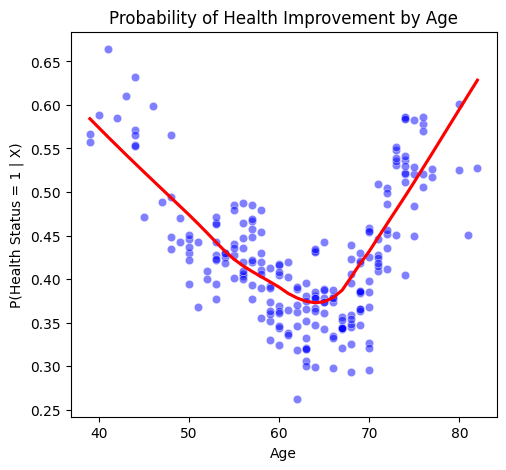

In [11]:
# Visualize Probability of Health Improvement by Age
plt.figure(figsize=(5.5, 5))
sns.scatterplot(data=results, x='age', y='prob_health_improved', color='blue', alpha=0.5)
sns.regplot(data=results, x='age', y='prob_health_improved', lowess=True, scatter=False, color='red')
plt.title('Probability of Health Improvement by Age')
plt.xlabel('Age')
plt.ylabel('P(Health Status = 1 | X)')
sns.set_style('white')  # Approximate theme_minimal()
plt.show()

## Summary and Conclusion

Probability Forests are a powerful tool for estimating conditional probabilities in classification tasks. They extend the random forest framework to provide probabilistic outputs, making them suitable for applications requiring uncertainty quantification. By averaging predictions across multiple trees, they offer robust and flexible estimates that can handle complex relationships between covariates and outcomes. This tutorial demonstrated how to implement a Probability Forest using the R package `{grf}` in Python, showcasing its ability to predict the probability of health improvement based on patient characteristics.
  


## References

1. [Probabilty Forest](https://grf-labs.github.io/grf/reference/probability_forest.html)